In [1]:
!git clone https://github.com/xserra/audio-coding-materials.git
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
from scipy.fft import fft
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.signal import decimate

Cloning into 'audio-coding-materials'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 17 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (17/17), 3.00 MiB | 5.41 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

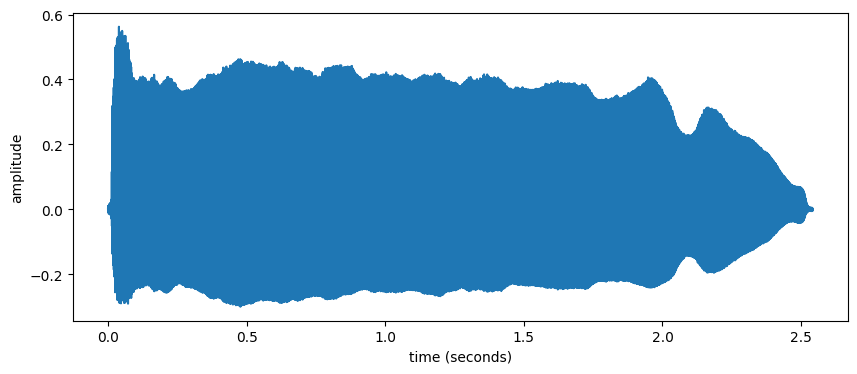

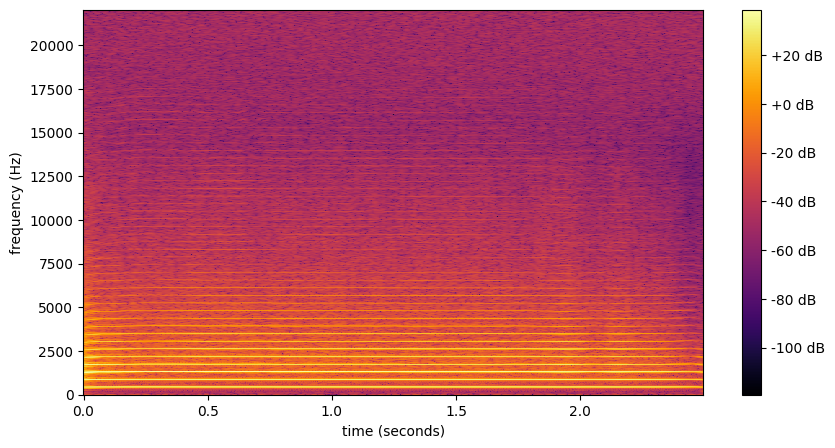

In [23]:
# read and display a sound
sound_array, sampling_rate = read_sound('/content/487465-trumpet.wav')
display_sound(sound_array, sampling_rate)

hop_size = 128
fft_size = 2048
display_spectrogram(sound_array, hop_size, fft_size, sampling_rate)

length original: 112076
length decimated: 14010


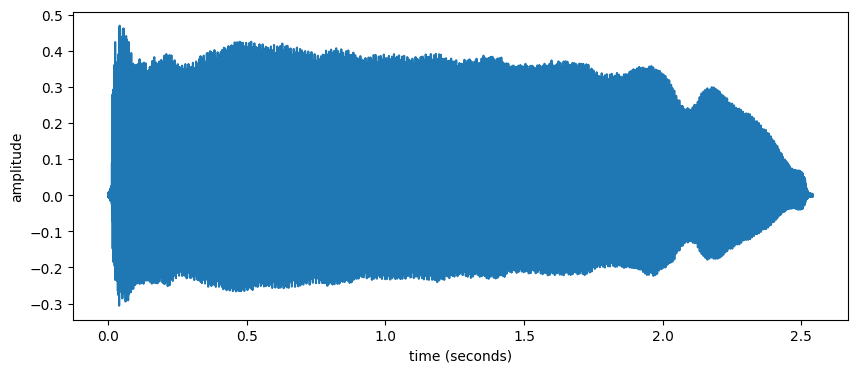

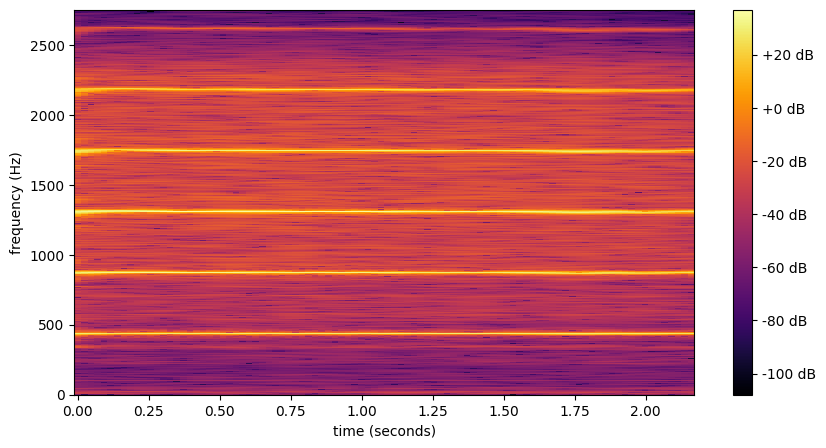

In [20]:
# change the decimate_factor (dowmnsample the sound) and find the lowest sampling rate for which you do not hear a difference
decimate_factor = 8
decimated_sound_array = decimate(sound_array, decimate_factor)
print("length original:", len(sound_array))
print("length decimated:", len(decimated_sound_array))
display_sound(decimated_sound_array, sampling_rate/decimate_factor)

hop_size = 128
fft_size = 2048
display_spectrogram(decimated_sound_array, hop_size, fft_size, sampling_rate/decimate_factor)

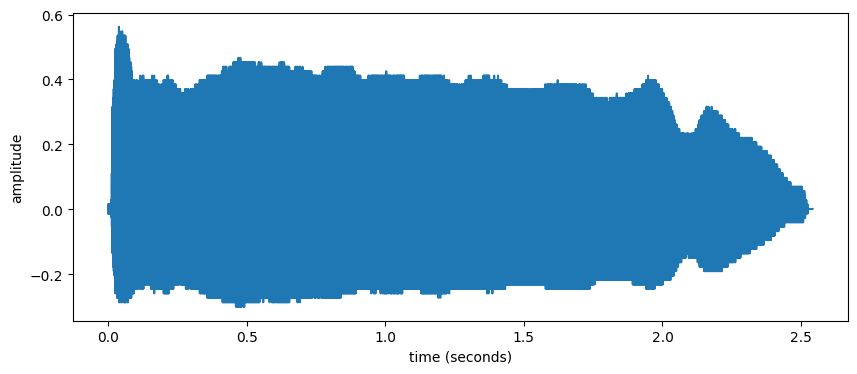

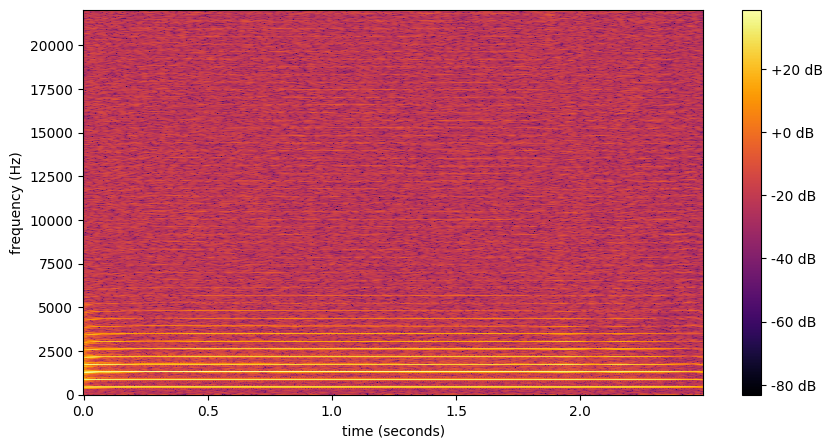

In [24]:
def quantize_signal(x, original_bits, target_bits):
  """Quantizes a signal x, assuming it originally had original_bits bits per sample, to target_bits per sample.
  Args:
    x (numpy.array): Array of samples as floating point values between -1 and 1
    original_bits (int): Number of bits of the signal that x represents
    target_bits (int): Number of bits per sample of the output signal
  """
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output

# quantize the sound
number_of_bits = 6
quantized_sound_array = quantize_signal(sound_array, 16, number_of_bits)
display_sound(quantized_sound_array, sampling_rate)

# display spectrogram of x
hop_size = 128
fft_size = 2048
display_spectrogram(quantized_sound_array, hop_size, fft_size, sampling_rate)